In [1]:
import numpy as np
import pandas as pd
import folium
import matplotlib.pyplot as plt
import reverse_geocoder

#用來正常顯示中文標籤的 
# plt.rcParams[ 'font.sans-serif']=[ 'Microsoft YaHei'] 
# #解決保存圖像是符號'-'顯示為方塊的問題 
# plt.rcParams[ 'axes.unicode_minus'] = False
#plt.rcParams['font.sans-serif']=['SimHei']



from folium.plugins import HeatMap
from sklearn.linear_model import LinearRegression

pd.set_option("display.max_rows", 1000)    #設定最大能顯示1000rows
pd.set_option("display.max_columns", 1000) #設定最大能顯示1000columns
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']  
指定默認字形：解決plot不能顯示中文問題
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
z_df = pd.read_csv("https://drive.google.com/uc?id=1LRgxN2ArFB82VbqloPyXTKU37gxFM5Hx") # zeroaccess.csv
s_df = pd.read_csv("https://drive.google.com/uc?id=1PZgOIwkrISYp8r3xdA-DrWkyOx1TZgy_") # state-internets.csv
c_df = pd.read_csv("https://drive.google.com/uc?id=1PsrGcWk0v89Tce8W-LhwMGrdtbFzYeMT") # county-data.csv

In [3]:
print(z_df.shape, s_df.shape, c_df.shape)

(808446, 2) (49, 3) (3072, 6)


In [4]:
z_df.head()

,lat,long
0,-10.0000,-55.0000
1,38.0888,-78.5592
2,38.9990,-84.6266
3,48.6210,7.4944
4,43.2342,-86.2484


In [5]:
s_df.head()

,state,population,internet
0,Alabama,4758191,3092273
1,Arizona,6665093,5230474
2,Arkansas,2919815,1949869
3,California,37350092,29758896
4,Colorado,5077553,4058749


In [6]:
s_df[s_df.state == 'District of Columbia']

,state,population,internet
7,District of Columbia,605959,463503


In [7]:
c_df.head()

,subregion,region,pop,income,ipaddr,ufo2010
0,abbeville,south carolina,25101,34670,30330,2
1,acadia,louisiana,61912,37970,38203,6
2,accomack,virginia,33341,41595,41338,2
3,ada,idaho,409061,55304,1035427,59
4,adair,iowa,7481,47623,3762,0


### plot zeroAccess infection instances on a earth map

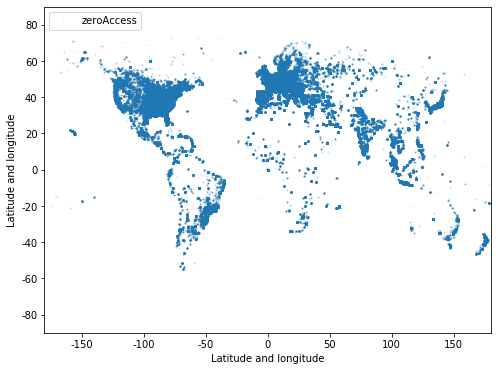

In [8]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111) #總共1 x 1的區域 然後只有一個圖

ax.scatter(z_df.long, z_df.lat, alpha = 0.1, s = 1, label = "zeroAccess") #alpha透明度
ax.set_xlim(-180,180)
ax.set_ylim(-90,90)

plt.xlabel("Latitude and longitude")
plt.ylabel("Latitude and longitude")
plt.legend(loc='upper left')
plt.show()


In [9]:
#zoom_start是比例尺 location[經度,緯度],height="50%", width="50%" 縮放整張圖的大一小
mapa = folium.Map(location=(10, 10), zoom_start=1.5, tiles="Stamen Toner", height="80%", width="80%")
loc_li = list(zip(z_df.lat, z_df.long))[:10000] # <--- change data size
HeatMap(loc_li, radius=15).add_to(mapa) # <-----------------------change radius
mapa

In [10]:
# {'lat': '51.51116', 'lon': '-0.18426', 'name': 'Bayswater', 
#  'admin1': 'England', 'admin2': 'Greater London', 'cc': 'GB'}

# batch implementation
def rgr_batch(lat_long_df):
    cord_li = []
    for ind in lat_long_df.index:
        cord_li.append((lat_long_df['lat'][ind], lat_long_df['long'][ind]))  #list裡面裝著tuple（經度，緯度）
    result_dict_li = reverse_geocoder.search(cord_li)  #反向地理編碼器採用緯度/經度坐標，並返回最近的城鎮/城市。
    return pd.DataFrame(result_dict_li).drop(["lat", "lon"], axis = 1) #drop掉兩個欄位

In [11]:
# batch implementation
sample_df = z_df.head(50000) # <------ only use some data, because it takes time
country_df = rgr_batch(sample_df)
df = sample_df.join(country_df).rename(columns={'name':'City', 'admin1': 'State', 'admin2':'County', 'cc':"country_code", })
df

Loading formatted geocoded file...


,lat,long,City,State,County,country_code
0,-10.0000,-55.0000,Alta Floresta,Mato Grosso,Alta Floresta,BR
1,38.0888,-78.5592,Charlottesville,Virginia,City of Charlottesville,US
2,38.9990,-84.6266,Florence,Kentucky,Boone County,US
3,48.6210,7.4944,Marlenheim,Alsace,Departement du Bas-Rhin,FR
4,43.2342,-86.2484,Muskegon,Michigan,Muskegon County,US
...,...,...,...,...,...,...
49995,53.1271,18.0200,Bydgoszcz,Kujawsko-Pomorskie,Bydgoszcz,PL
49996,42.6757,-82.7773,New Baltimore,Michigan,Macomb County,US
49997,43.5417,21.7078,Aleksinac,Central Serbia,Nisavski Okrug,RS
49998,28.2397,-82.7388,New Port Richey,Florida,Pasco County,US


In [12]:
df.loc[df['City']=='District of Columbia', [ "State", "City","County"]]

,State,City,County


# Question #1:
Plot a figure to show # of attack in each country

https://stackoverflow.com/questions/48939795/how-to-plot-a-count-bar-chart-with-a-pandas-df-grouping-by-one-categorical-colu

https://zhuanlan.zhihu.com/p/29986906

Text(0, 0.5, 'number')

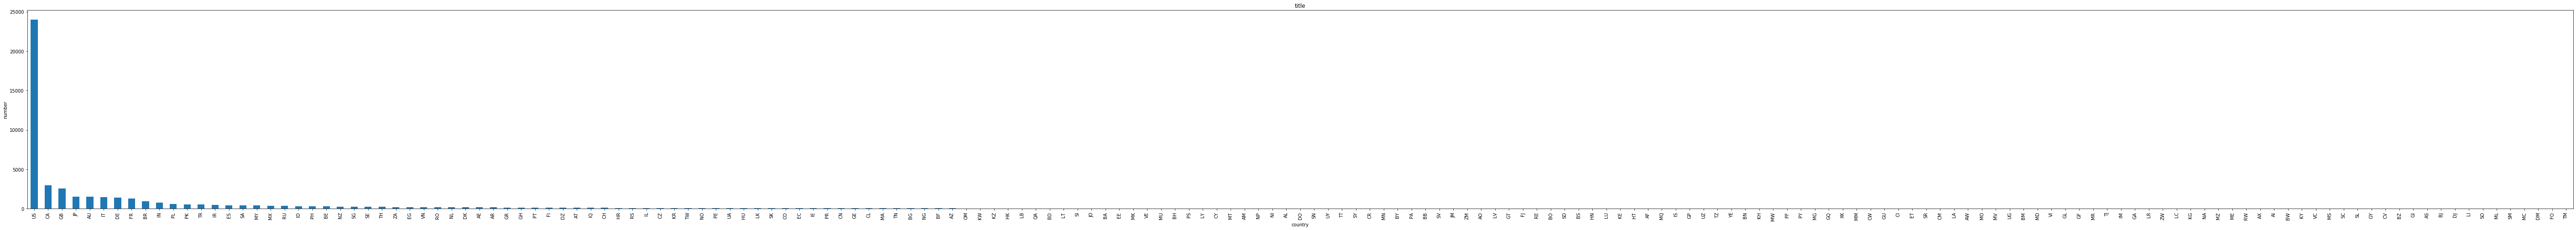

In [13]:
ax = df['country_code'].value_counts().plot(kind='bar',
                                     figsize=(100, 8),
                                     title='title')
ax.set_xlabel('country')
ax.set_ylabel('number')

# Question #2:
Plot a figure to show % of attack in each country Ignore countries that are < 1%  

Text(17.200000000000045, 0.5, 'number (%)')

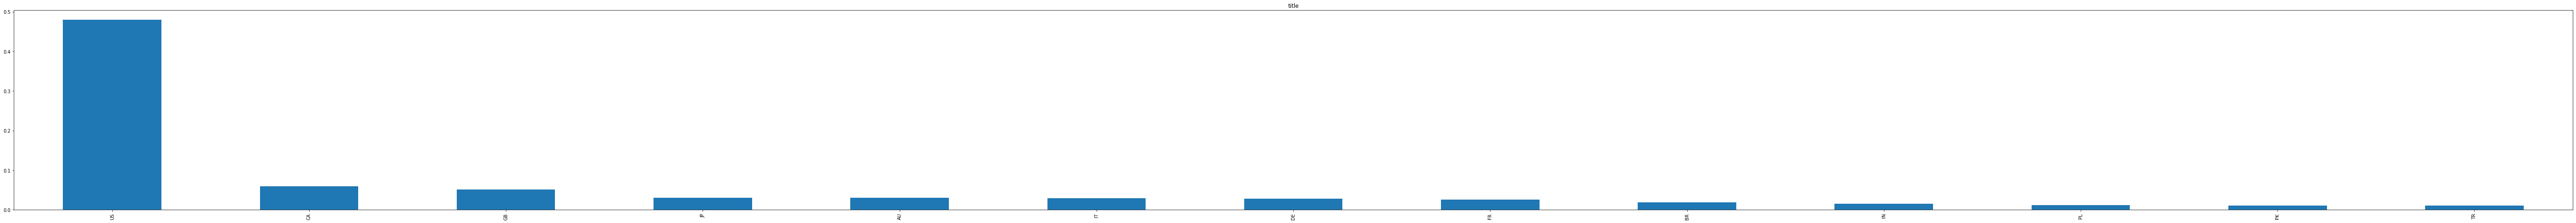

In [14]:
a = df['country_code'].value_counts()/(df['country_code'].value_counts().sum())
a[a >= 0.01].plot(kind='bar',figsize=(100, 8), title='title')
ax.set_xlabel('country')
ax.set_ylabel('number (%)')

In [15]:
(df.country_code.value_counts()/(df.country_code.value_counts().sum()))[:13]

US    0.47974
CA    0.05932
GB    0.05128
JP    0.03008
AU    0.03002
IT    0.02964
DE    0.02824
FR    0.02622
BR    0.01928
IN    0.01496
PL    0.01154
PK    0.01096
TR    0.01052
Name: country_code, dtype: float64

# Question #3:
Only show US data and map. Show US state data.

Which state/ciry has severe attack? Why?

Hint: recall a network tool named 'whois' ...

In [16]:
df.head()

,lat,long,City,State,County,country_code
0,-10.0000,-55.0000,Alta Floresta,Mato Grosso,Alta Floresta,BR
1,38.0888,-78.5592,Charlottesville,Virginia,City of Charlottesville,US
2,38.9990,-84.6266,Florence,Kentucky,Boone County,US
3,48.6210,7.4944,Marlenheim,Alsace,Departement du Bas-Rhin,FR
4,43.2342,-86.2484,Muskegon,Michigan,Muskegon County,US


#### 只顯示美國的州

In [17]:

df.loc[df['country_code']=='US', [ "lat", "long", "City","State","country_code"]]

#df.loc[df.country_code=='US', ["State", "country_code"]].head() 這樣也可以
#df.loc[:,['State','City']] 以及這樣也可以
#df.groupby('a').b.value_counts().reset_index(name='counts')
#https://kknews.cc/zh-tw/tech/lk6vr2.html

,lat,long,City,State,country_code
1,38.0888,-78.5592,Charlottesville,Virginia,US
2,38.9990,-84.6266,Florence,Kentucky,US
4,43.2342,-86.2484,Muskegon,Michigan,US
6,44.8012,-68.7778,Bangor,Maine,US
8,36.0580,-88.8253,Bradford,Tennessee,US
...,...,...,...,...,...
49992,40.6374,-79.7264,Brackenridge,Pennsylvania,US
49994,38.4380,-122.6753,Santa Rosa,California,US
49996,42.6757,-82.7773,New Baltimore,Michigan,US
49998,28.2397,-82.7388,New Port Richey,Florida,US


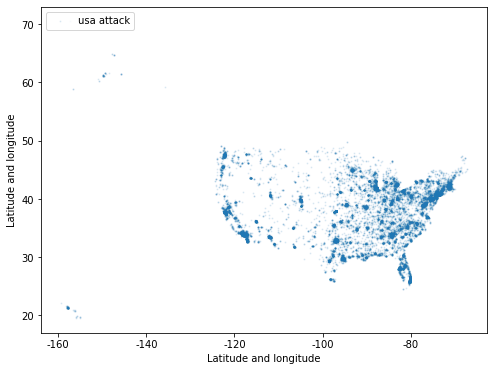

In [18]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111) #總共1 x 1的區域 然後只有一個圖

ax.scatter(df[df.country_code == 'US'].long, df[df.country_code == 'US'].lat, alpha = 0.1, s = 1,label = 'usa attack') #alpha透明度
# ax.set_xlim(-160,100)
# ax.set_ylim(-0,70)

plt.xlabel("Latitude and longitude")
plt.ylabel("Latitude and longitude")
plt.legend(loc='upper left')
plt.show()

#### 美國各州共有幾個

In [19]:
attack = df[df.country_code == 'US'].State.value_counts()

In [20]:
attack

California          2293
Texas               2003
Florida             1425
Kansas              1371
New York            1315
Pennsylvania         970
Illinois             948
Ohio                 914
Georgia              841
North Carolina       759
Michigan             715
New Jersey           669
Virginia             526
Arizona              503
Washington           502
Missouri             480
Wisconsin            472
Indiana              458
Massachusetts        453
Maryland             430
Tennessee            425
Alabama              412
Minnesota            405
Colorado             394
South Carolina       386
Kentucky             373
Louisiana            366
Oklahoma             293
Arkansas             262
Mississippi          241
Oregon               235
Iowa                 228
Connecticut          226
Nevada               187
Utah                 164
West Virginia        161
Nebraska             144
New Mexico           133
Maine                113
Idaho                 99


In [21]:
df[df.country_code == 'US'].groupby(['State','City'])['City'].count().sort_values(ascending=False) #descending

State         City         
Kansas        Peabody          1152
Texas         Houston           238
California    Los Angeles       179
Illinois      Chicago           144
Arizona       Phoenix           142
                               ... 
Pennsylvania  Quarryville         1
              Radnor              1
Maryland      Hurlock             1
              Huntingtown         1
Mississippi   Ocean Springs       1
Name: City, Length: 6660, dtype: int64

https://medium.com/@b89202027_37759/%E5%AF%A6%E7%94%A8%E4%BD%86%E5%B8%B8%E5%BF%98%E8%A8%98%E7%9A%84pandas-dataframe%E5%B8%B8%E7%94%A8%E6%8C%87%E4%BB%A4-1-976f48eb2bd5

#### Which state/city has severe attack? Why?

In [22]:
print("Kansas(state)Peabody(city) has severe attach , because it has 1152 attacks")

Kansas(state)Peabody(city) has severe attach , because it has 1152 attacks


# Question #4:
Is there anything wrong with these states?

In [23]:
s_df[['state','population']].sort_values(by='population',ascending=False)

,state,population
3,California,37350092
41,Texas,25042738
30,New York,19746813
8,Florida,18732783
11,Illinois,13046084
36,Pennsylvania,12737230
33,Ohio,11663946
20,Michigan,10074498
9,Georgia,9932505
31,North Carolina,9479467


In [24]:
print(" attack 數量大致上和人口成正比，人口數越多，attack數量就越多")

 attack 數量大致上和人口成正比，人口數越多，attack數量就越多


# 各州人口

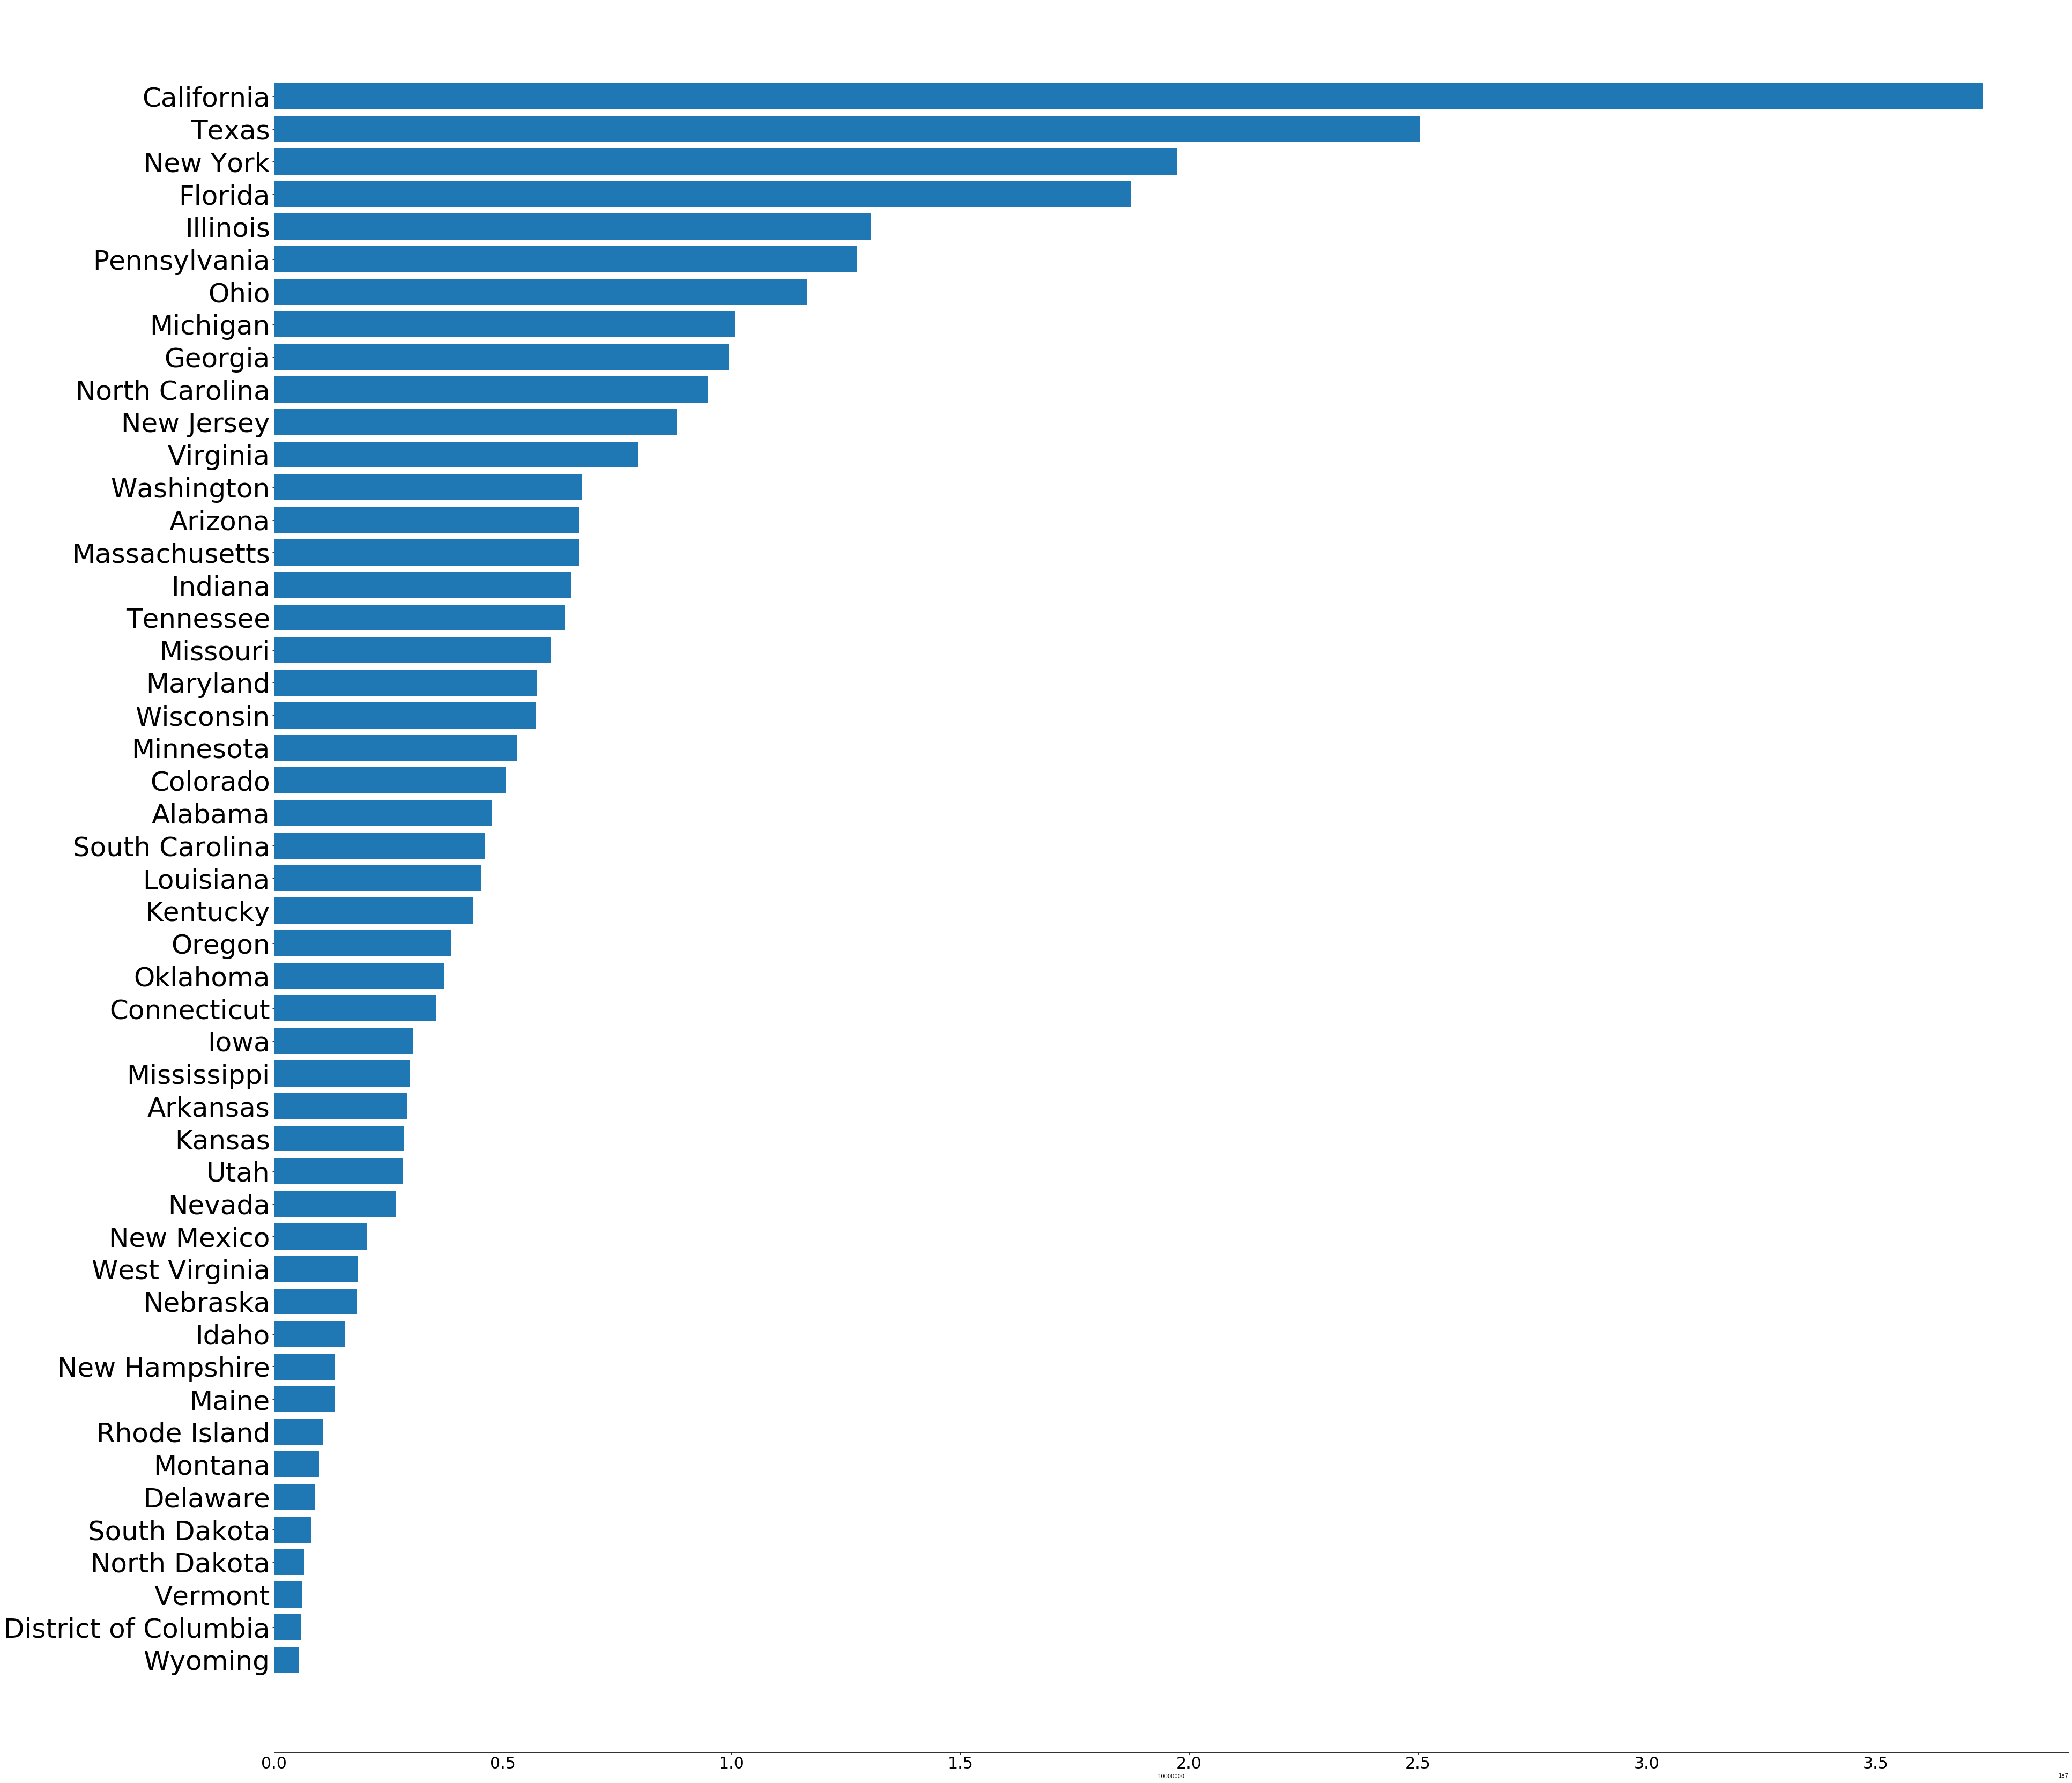

In [25]:
plt.figure(figsize=(60,60))

plt.barh(s_df[['state','population']].sort_values(by='population',ascending=True).state, s_df[['state','population']].sort_values(by='population',ascending=True).population)

plt.xticks(fontsize=30)
plt.yticks(fontsize=50)
plt.xlabel("10000000")
plt.show()

In [26]:
att_pc = attack / np.sum(attack)

In [27]:
df1= pd.DataFrame(
                {"attack": attack,
                "att_pc":att_pc})
df1.index = [i[:1].upper()+i[1:].lower() for i in df1.index]
df1

,attack,att_pc
California,2293,0.095593
Texas,2003,0.083504
Florida,1425,0.059407
Kansas,1371,0.057156
New york,1315,0.054821
Pennsylvania,970,0.040439
Illinois,948,0.039521
Ohio,914,0.038104
Georgia,841,0.035061
North carolina,759,0.031642


# Question #5:
Are the attack occurances in each state related to state population?

Try a bar chart!

#### 先把兩個資料整併在同一個dataframe

In [28]:
s_df.index = s_df.state
s_df.head()

,state,population,internet
state,,,
Alabama,Alabama,4758191,3092273
Arizona,Arizona,6665093,5230474
Arkansas,Arkansas,2919815,1949869
California,California,37350092,29758896
Colorado,Colorado,5077553,4058749


In [29]:
pop_pc = s_df.population / np.sum(s_df.population)
data = pd.DataFrame(pop_pc)
data = data.rename(columns={"population": "pop_pc"})
data.index = [i[:1].upper()+i[1:].lower() for i in data.index]
data

,pop_pc
Alabama,0.015438
Arizona,0.021625
Arkansas,0.009473
California,0.121181
Colorado,0.016474
Connecticut,0.011535
Delaware,0.002902
District of columbia,0.001966
Florida,0.060778
Georgia,0.032226


In [31]:

df3 = pd.merge(df1, data, left_index=True, right_index=True,how='outer')
df3.index.names = ['state']
df3.index = [i[:1].upper()+i[1:].lower() for i in df3.index] #把index名稱 改成首字大寫其餘小寫，以利後續merge
df3

,attack,att_pc,pop_pc
Alabama,412.0,0.017176,0.015438
Alaska,46.0,0.001918,NaN
Arizona,503.0,0.020970,0.021625
Arkansas,262.0,0.010923,0.009473
California,2293.0,0.095593,0.121181
Colorado,394.0,0.016426,0.016474
Connecticut,226.0,0.009422,0.011535
Delaware,68.0,0.002835,0.002902
District of columbia,NaN,NaN,0.001966
Florida,1425.0,0.059407,0.060778


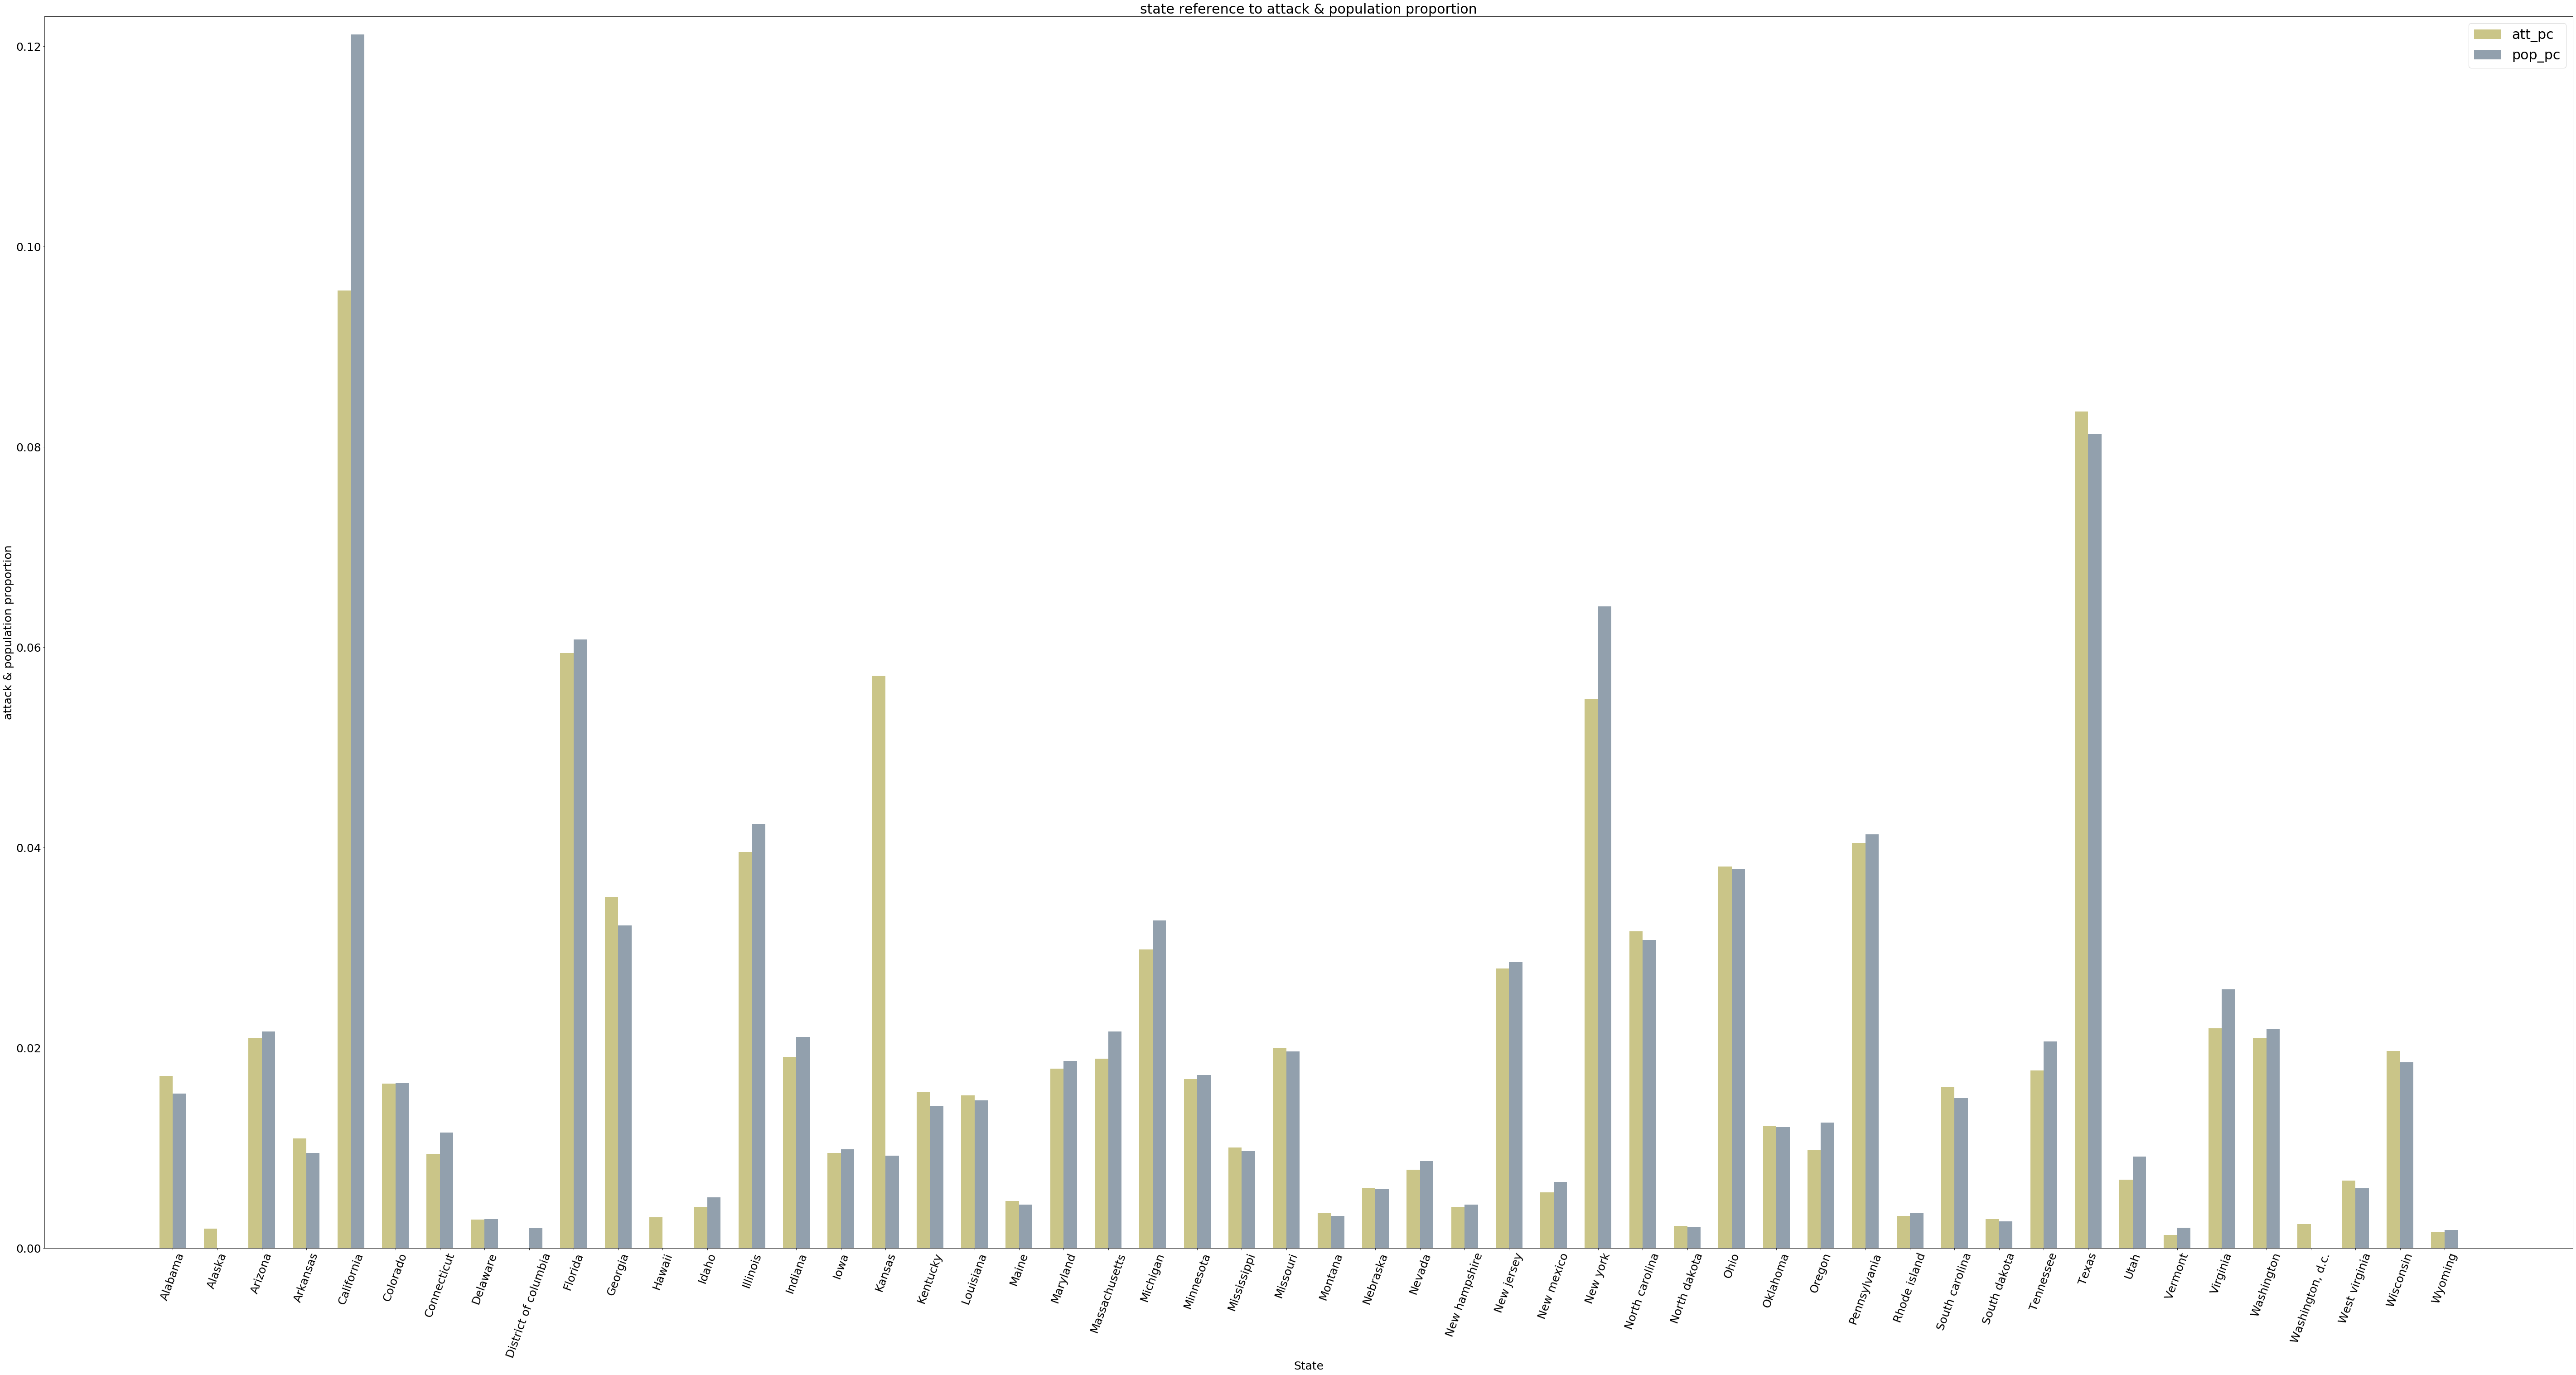

In [32]:
bar_width = 0.3 #移動距離

labels = ["{}".format(i) for i in df3.index]
plt.figure(figsize=(100,50))
plt.bar(np.arange(len(df3.index)), df3.att_pc, width = bar_width,tick_label=labels, align='edge' , label = 'att_pc', color = 'darkkhaki', alpha = 0.8) 
plt.bar(np.arange(len(df3.index))+bar_width, df3.pop_pc, width = bar_width,tick_label=labels, align='edge' , label = 'pop_pc', color = 'lightslategray', alpha = 0.8)

plt.xlabel('State', fontsize=25)
plt.ylabel('attack & population proportion', fontsize=25)
plt.title( 'state reference to attack & population proportion',fontsize=30)

# 設定刻度字型大小
plt.xticks(fontsize=25, rotation = 70)
plt.yticks(fontsize=25)
plt.ylim(0, 0.123)



plt.legend(loc='upper right', fontsize=30)




plt.show()

https://codertw.com/%E7%A8%8B%E5%BC%8F%E8%AA%9E%E8%A8%80/362934/

https://i.stack.imgur.com/lFZum.png

https://blog.csdn.net/weixin_40907382/article/details/79919253

# UFO?
Try to use county-data.csv data to predict the attack counts for each state by liner regression.

Which feature is the best?

In [33]:
df4 = c_df[['region','pop','income','ipaddr','ufo2010']]
df4

,region,pop,income,ipaddr,ufo2010
0,south carolina,25101,34670,30330,2
1,louisiana,61912,37970,38203,6
2,virginia,33341,41595,41338,2
3,idaho,409061,55304,1035427,59
4,iowa,7481,47623,3762,0
...,...,...,...,...,...
3067,arizona,200022,41441,99991,53
3068,colorado,10119,44991,7662,1
3069,texas,14290,26009,3833,0
3070,texas,11961,23952,545,1


#### 發現有重複值

In [34]:
df4[df4.region == 'texas']

,region,pop,income,ipaddr,ufo2010
59,texas,58190,40577,41981,0
61,texas,16117,51598,8184,2
63,texas,87597,39325,40444,4
73,texas,23818,44129,0,0
75,texas,8735,53113,11627,1
...,...,...,...,...,...
3022,texas,42022,41260,26502,0
3058,texas,8075,48173,4978,0
3065,texas,18339,39898,18429,0
3069,texas,14290,26009,3833,0


#### 去除重複並且去掉index名稱

In [35]:
df4_group=df4.groupby(df4.region, as_index=False).sum()
df4_group.index = df4_group.region
df4_group.index.names = ['state']
df4_group = df4_group.drop("region", axis = 1)
df4_group.index = [i[:1].upper()+i[1:].lower() for i in df4_group.index]
df4_group

,pop,income,ipaddr,ufo2010
Alabama,4822023,2522962,22542601,250
Arizona,6532974,612727,62062174,1250
Arkansas,2949131,2677866,4810526,265
California,38041430,3241756,156511903,3769
Colorado,5129284,3206281,22787577,513
Connecticut,3590347,565060,40993589,280
Delaware,917092,172156,19378182,74
District of columbia,632323,61835,10759507,1
Florida,19317568,2990011,23716071,1465
Georgia,9919945,6433814,20947043,548


In [36]:
df5 = pd.merge(df4_group,df3,left_index=True, right_index=True,how='outer')
df5

,pop,income,ipaddr,ufo2010,attack,att_pc,pop_pc
Alabama,4822023.0,2522962.0,22542601.0,250.0,412.0,0.017176,0.015438
Alaska,NaN,NaN,NaN,NaN,46.0,0.001918,NaN
Arizona,6532974.0,612727.0,62062174.0,1250.0,503.0,0.020970,0.021625
Arkansas,2949131.0,2677866.0,4810526.0,265.0,262.0,0.010923,0.009473
California,38041430.0,3241756.0,156511903.0,3769.0,2293.0,0.095593,0.121181
Colorado,5129284.0,3206281.0,22787577.0,513.0,394.0,0.016426,0.016474
Connecticut,3590347.0,565060.0,40993589.0,280.0,226.0,0.009422,0.011535
Delaware,917092.0,172156.0,19378182.0,74.0,68.0,0.002835,0.002902
District of columbia,632323.0,61835.0,10759507.0,1.0,NaN,NaN,0.001966
Florida,19317568.0,2990011.0,23716071.0,1465.0,1425.0,0.059407,0.060778


In [37]:
regr = LinearRegression()

In [38]:
df5.dropna(inplace=True)

In [41]:
X = df5.loc[:, :].values
y = df5.iloc[:, 1].values

In [42]:
regr.fit(df5[['pop','income','ipaddr','ufo2010']].values,df5.attack.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [48]:
print('intercept:',regr.intercept_)
print('coefficient:',regr.coef_)

intercept: -12.765104130708494
coefficient: [ 6.11127167e-05  4.32120599e-05  1.37605988e-07 -2.64018980e-02]


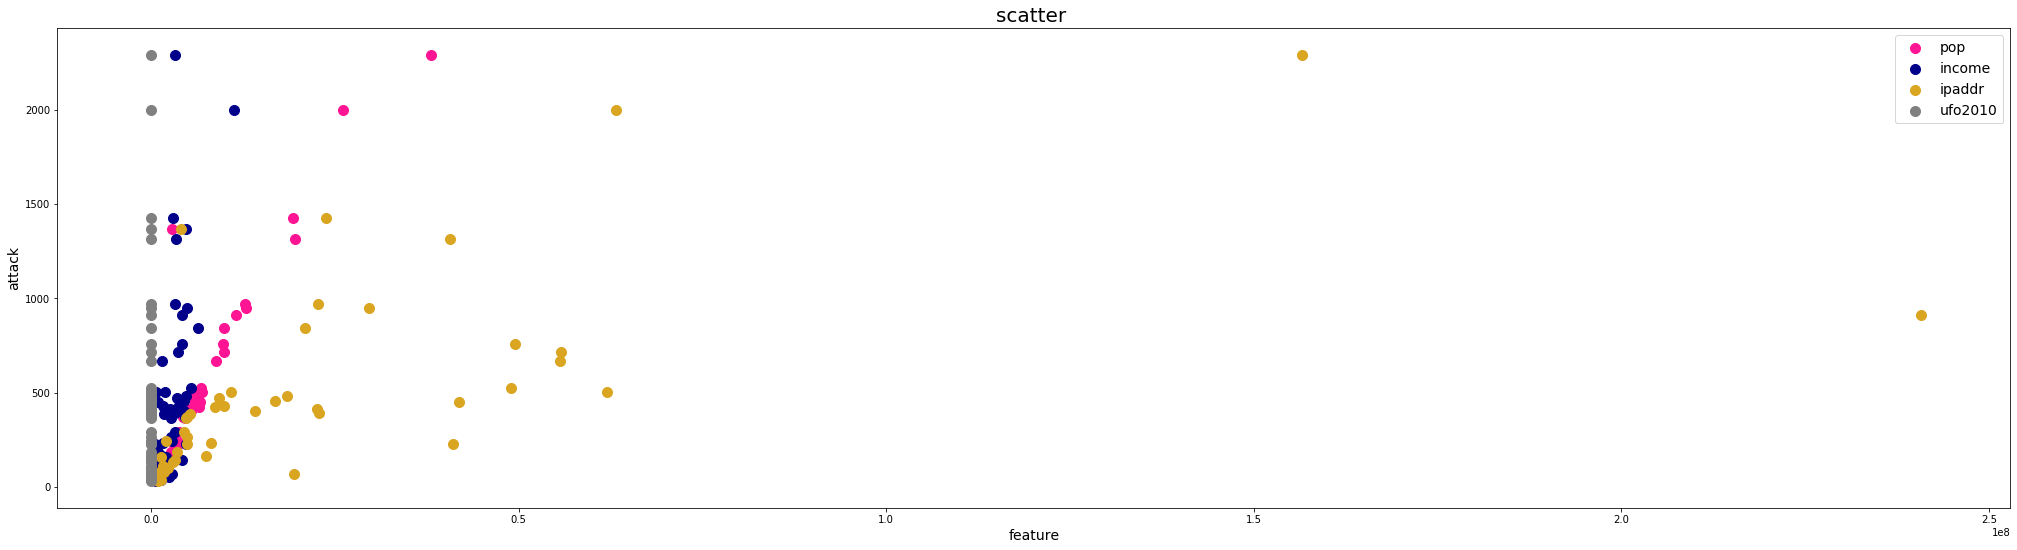

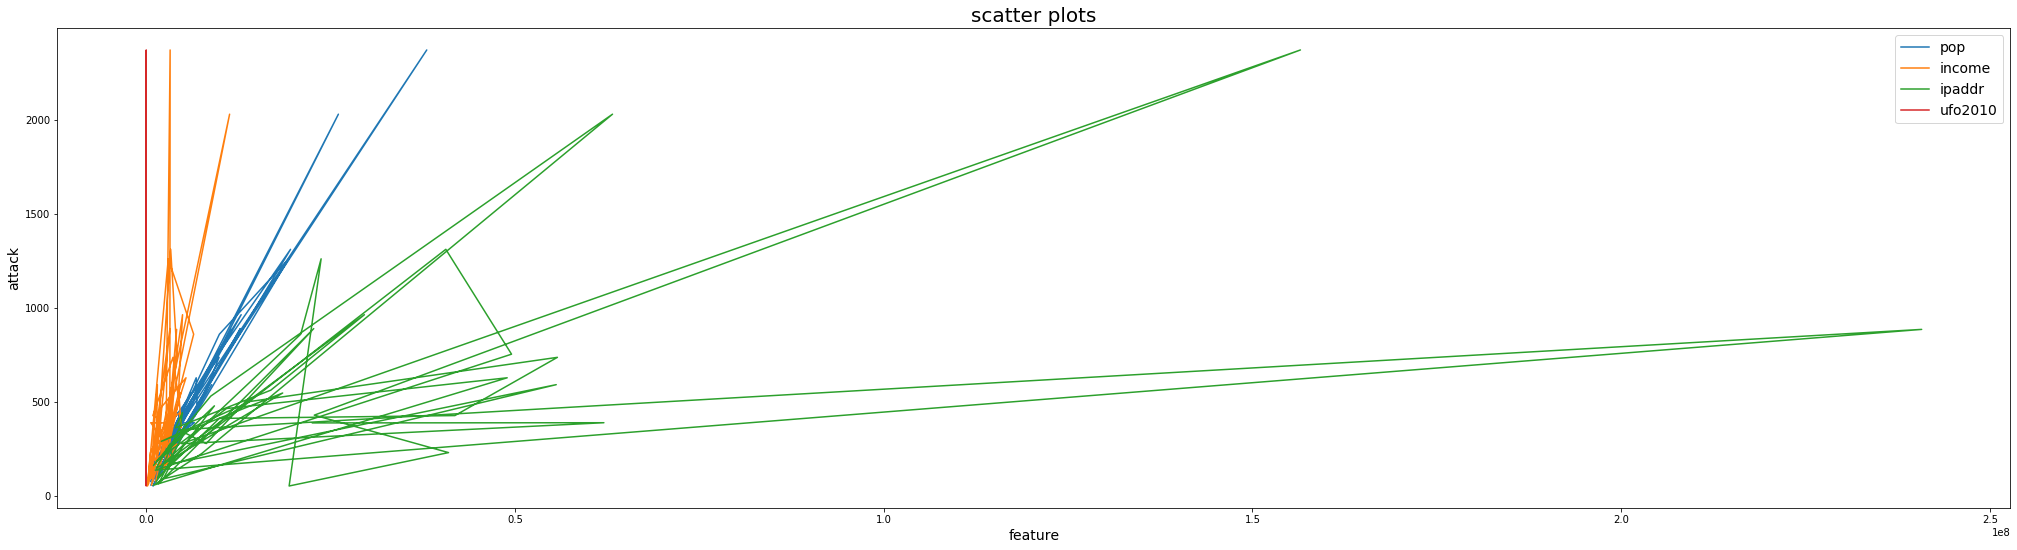

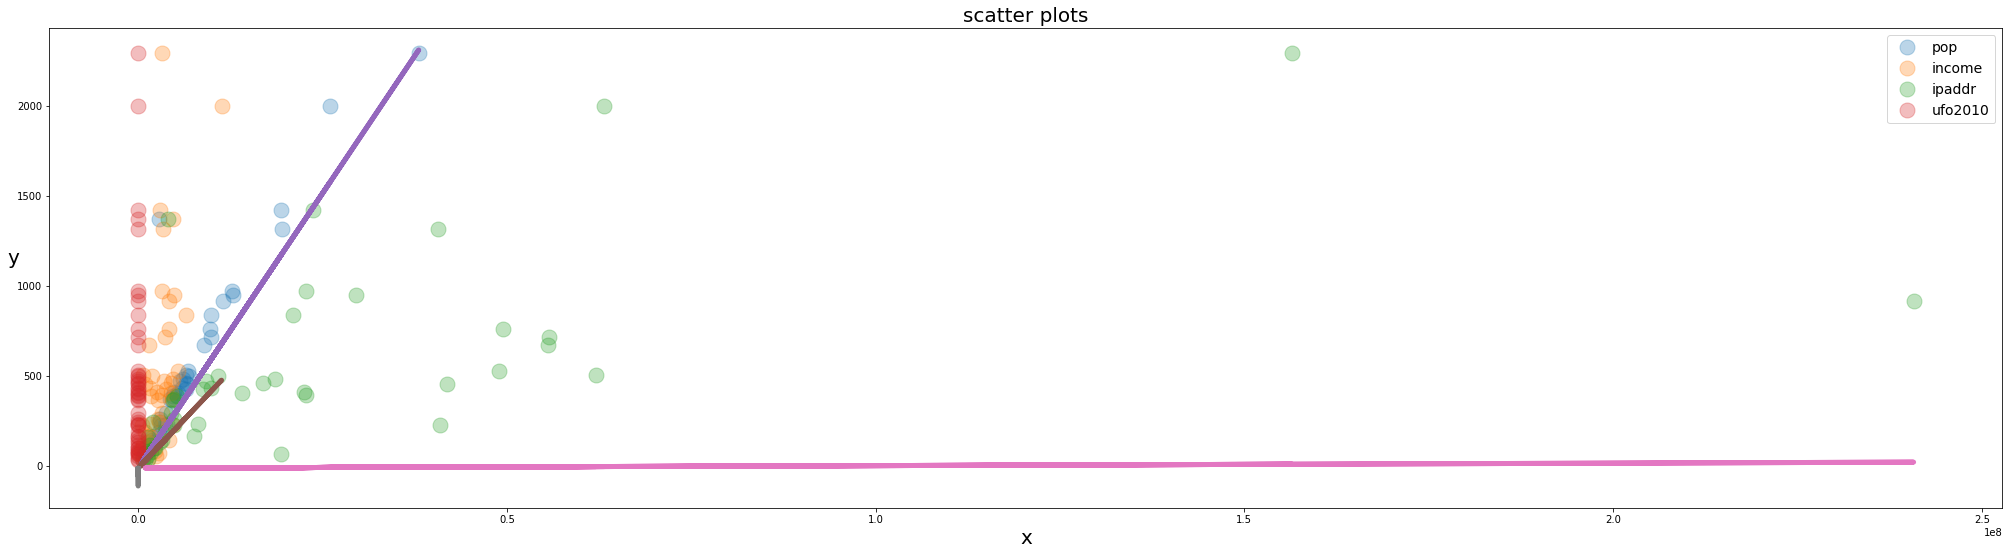

In [46]:
yPred = regr.predict(df5[['pop','income','ipaddr','ufo2010']].values)

plt.figure(figsize=(35,30))
plt.subplot(3,1,1)
plt.scatter(df5[['pop']].values , df5.attack.values , s=100, c='deeppink', marker='o')
plt.scatter(df5[['income']].values ,df5.attack.values, s=100, c='darkblue', marker='o')
plt.scatter(df5[['ipaddr']].values ,df5.attack.values, s=100, c='goldenrod', marker='o')
plt.scatter(df5[['ufo2010']].values ,df5.attack.values, s=100, c='gray', marker='o')
plt.title('scatter ',fontsize=20)
plt.xlabel(u'feature',fontsize=14)
plt.ylabel(u'attack',fontsize=14)
plt.legend(['pop', 'income', 'ipaddr','ufo2010'],fontsize=14,loc='upper right')



plt.figure(figsize=(35,30))
# plt.scatter(df5[['pop','income','ipaddr','ufo2010']].values, df5.attack.values)
plt.title('plots',fontsize=20)
plt.xlabel(u'feature',fontsize=14)
plt.ylabel(u'attack',fontsize=14)
plt.subplot(3,1,2)
plt.plot(df5[['pop','income','ipaddr','ufo2010']].values,yPred)
plt.legend(['pop', 'income', 'ipaddr','ufo2010'],fontsize=14,loc='upper right')
plt.title('scatter plots',fontsize=20)
plt.xlabel(u'feature',fontsize=14)
plt.ylabel(u'attack',fontsize=14)

plt.figure(figsize=(35,30))
plt.subplot(3,1,3)
plt.title('scatter plots',fontsize=20)
plt.xlabel(u'feature',fontsize=14)
plt.ylabel(u'attack',fontsize=14)
plt.plot(df5[['pop']].values, df5.attack.values,'o',markersize=15,alpha=0.3,label='pop')
plt.plot(df5[['income']].values, df5.attack.values,'o',markersize=15,alpha=0.3,label='income')
plt.plot(df5[['ipaddr']].values, df5.attack.values,'o',markersize=15,alpha=0.3,label='ipaddr')
plt.plot(df5[['ufo2010']].values, df5.attack.values,'o',markersize=15,alpha=0.3,label='ufo2010')
plt.plot(df5[['pop','income','ipaddr','ufo2010']].values, regr.intercept_+ regr.coef_*df5[['pop','income','ipaddr','ufo2010']].values,linewidth=5)
plt.legend(fontsize=14,loc='upper right')
plt.xlabel('x',fontsize=20)
plt.ylabel('y',fontsize=20,rotation=0)

plt.show()


In [49]:
df5.corr()

,pop,income,ipaddr,ufo2010,attack,att_pc,pop_pc
pop,1.000000,0.483770,0.617194,0.915315,0.932930,0.932930,0.999395
income,0.483770,1.000000,0.223794,0.323558,0.585952,0.585952,0.484327
ipaddr,0.617194,0.223794,1.000000,0.588630,0.569404,0.569404,0.624736
ufo2010,0.915315,0.323558,0.588630,1.000000,0.828464,0.828464,0.913291
attack,0.932930,0.585952,0.569404,0.828464,1.000000,1.000000,0.931870
att_pc,0.932930,0.585952,0.569404,0.828464,1.000000,1.000000,0.931870
pop_pc,0.999395,0.484327,0.624736,0.913291,0.931870,0.931870,1.000000


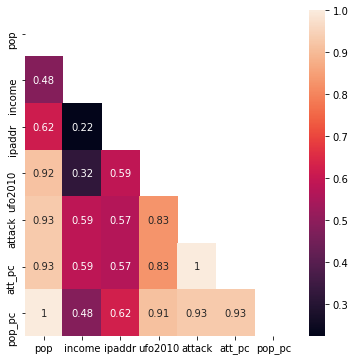

In [52]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 6)) 
mask = np.zeros_like(df5.corr()) 
mask[np.triu_indices_from(mask)] = 1 
sns.heatmap(df5.corr(), mask= mask, ax= ax, annot= True)


UFO cause may ZeroAccess infection?